# Selezione del modello

In questo notebook proveremo alcuni metodi di selezione dei modelli. Partendo dai due modelli con le migliori performance del notebook 3 cercheremo i valori ottimali degli iperparametri, valutando varie configurazioni tramite cross-validation. Successivamente testeremo la migliore configurazione sul test set.

Per prima cosa importiamo i dati e alcune librerie.

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="600" height="400">

In [1]:
import warnings
import os 
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
def get_data(filename:str) -> tuple:
    path = os.path.join("datasets", filename)
    with open(path, "rb") as file:
        data = pickle.load(file)
    return data

In [3]:
classification_data = get_data("classification_data.pickle")
regression_data = get_data("regression_data.pickle")

## Selezione degli iperparametri - Classificazione

Nel notebook precedente abbiamo scelto `RandomForestClassifier` come modello principale per il problema di classificazione. 
Ora selezioneremo gli iperparametri del modello tramite lo score di 5-fold cross-validation sul train set.

In genere questo processo viene svolto congiuntamente alla selezione del modello candidato, in modo da avere una visione più completa delle possibili performance del modello.

A tale scopo utilizzeremo la funzione `cross_val_score` di `sklearn`, che ci permette di automatizzare il processo di cross-validation.

In [4]:
X_train, y_train, X_test, y_test = classification_data

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42)

# Perform a 10-fold cross validation
scores = cross_val_score(rfc, X_train, y_train, cv=10)

,Random Forest CV
1,0.930720
2,0.943912
3,0.929321
4,0.942544
5,0.939808
6,0.932969
7,0.937073
8,0.938896
9,0.930689
10,0.935249


'Mean: Random Forest CV    0.936118\ndtype: float64'

<Axes: ylabel='Frequency'>

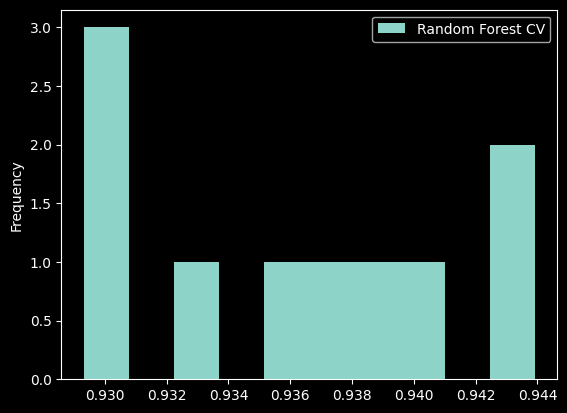

In [6]:
scores = pd.DataFrame(scores, columns=["Random Forest CV"], index=np.arange(1, scores.shape[0]+1))
display(scores, f"Mean: {scores.mean()}")
scores.plot.hist()

Applichiamo ora il metodo per trovare dei buoni parametri per il modello. A tale scopo dovremo scegliere uno spazio dei parametri da esplorare e un metodo per farlo. Qui proponiamo 3 approcci possibili.

### Metodo 1 - GridSearchCV

Utilizzeremo il metodo `GridSearchCV` di `sklearn`, che permette di esplorare uno spazio dei parametri con una ricerca esaustiva.

In [7]:
params = {
    # 'n_estimators' rappresenta il numero di alberi nella foresta. Di solito il
    # numero più alto di alberi è il migliore per apprendere i dati. Tuttavia, 
    # aggiungendo molti alberi può rallentare notevolmente il processo di addestramento, 
    # quindi di solito usiamo un numero ragionevole a seconda delle dimensioni del dataset.
    'n_estimators': [10, 100, 500],

    # 'max_depth' rappresenta la profondità di ciascun albero nella foresta. 
    # Più profondo è l'albero, più suddivisioni ha e cattura più informazioni sui dati 
    # e questa è la profondità massima a cui può crescere ciascun albero.
    'max_depth': [1,3,5],

    # 'min_samples_split' rappresenta il numero minimo di campioni necessari per dividere un nodo interno.
    # Questo può variare tra considerare almeno un campione in ciascun nodo 
    # a considerare tutti i campioni in ciascun nodo. Quando aumentiamo questo parametro,
    # l'albero diventa più vincolato in quanto deve considerare più campioni in ciascun nodo.
    'min_samples_split': [2, 5],

    # 'min_samples_leaf' è il numero minimo di campioni richiesti per essere in un nodo foglia.
    # Questo parametro è simile a min_samples_splits, tuttavia, descrive il numero minimo di
    # campioni alle foglie, alla base dell'albero.
    'min_samples_leaf': [2, 4],

    # 'max_features' rappresenta il numero di caratteristiche da considerare quando si cerca
    # la migliore suddivisione. Queste saranno selezionate in modo casuale. 
    # Come regola generale, la radice quadrata del numero totale di caratteristiche funziona
    # spesso molto bene, ma dovremmo controllare fino al 30-40% del numero totale di features.
    'max_features': ['sqrt', 'log2'],

    # 'bootstrap' viene utilizzato per il campionamento avviato. Ciò significa che per ogni albero
    # che viene costruito, considererebbe un insieme / sottoinsieme di righe distinte. Generalmente, 
    # l'opzione di avvio è impostata su True per un modello Random Forest.
    'bootstrap': [True, False],

    # 'criterion' è la funzione per misurare la qualità di una divisione. "gini" è per l'impurità di Gini 
    # e "entropy" è per il guadagno di informazione.
    'criterion': ['gini', 'entropy']
}

# Una funzione per contare il numero di combinazioni possibili:

def count_combinations(params: dict)-> int:

    result = 1
    for key in params:
        subset_count = 1
        if isinstance(params[key], list):
            subset_count=len(params[key])
        elif isinstance(params[key], dict):
            subset_count=count_combinations(params[key])
        result*=subset_count
    return result

display(count_combinations(params))
        

288

In [8]:
from sklearn.model_selection import GridSearchCV

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=params, cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 100, 500]})

Ora possiamo estrarre la configurazione ottimale dall'oggetto:

In [9]:
best_params = grid_search.best_params_
print("Best hyperparameters:\n",best_params,"\nwith GridSearchCV best score: {:.2%}".format(grid_search.best_score_))

Best hyperparameters:
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100} 
with GridSearchCV best score: 90.79%


Ora possiamo allenare il modello con la configurazione ottimale su tutto il train set e testarlo sul test set.

In [10]:
# Impostiamo i parametri ottimali per il modello
rfc.set_params(**best_params)

# Alleniamo il modello sul train set
rfc.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = rfc.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91      1128
         1.0       0.96      0.83      0.89      1091

    accuracy                           0.90      2219
   macro avg       0.91      0.90      0.90      2219
weighted avg       0.91      0.90      0.90      2219



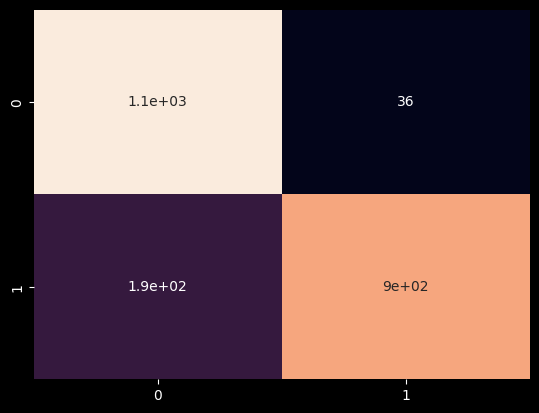

In [11]:
# Infine valutiamo le previsioni
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False);

### Metodo 2 - RandomizedSearchCV

A volte, specie se lo spazio dei parametri è molto grande e/o il modello complesso da allenare, la ricerca esaustiva può diventare estremamente costosa. Potrebbe quindi essere più ragionevole campionare lo spazio degli iperparametri. Un possibile metodo è il campionamento casuale di `RandomizedSearchCV`. 

In [12]:
from sklearn.model_selection import RandomizedSearchCV

more_params = {
    "n_estimators": list(range(400,601, 10)),
    "max_depth": list(range(3,11)),
    "min_samples_split": list(range(2,4)),
    "min_samples_leaf": list(range(3,6)),
    "max_features": ["sqrt"],
    "bootstrap": [True],
    "criterion": ["gini"],
}
print(count_combinations(more_params))

1008


In [13]:
random_search = RandomizedSearchCV(
    rfc, more_params, n_iter=100, cv=5, n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=5,
                                                    min_samples_leaf=4,
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'criterion': ['gini'],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [3, 4, 5],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': [400, 410, 420, 430,
                                                         440, 450, 460, 470,
                                                         480, 490, 500, 510,
                                                         520, 530, 540, 550,
                                                         560, 570, 580, 590,
                                                         600]},
                   random_state=42)

Come prima estraiamo la combinazione ottimale, fittiamo sul train e calcoliamo lo score.

In [14]:
best_params = random_search.best_params_
print("Best hyperparameters:\n",best_params,"\nwith RandomizedSearchCV best score: {:.2%}".format(grid_search.best_score_))

Best hyperparameters:
 {'n_estimators': 590, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True} 
with RandomizedSearchCV best score: 90.79%


              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91      1128
         1.0       0.94      0.87      0.90      1091

    accuracy                           0.91      2219
   macro avg       0.91      0.91      0.91      2219
weighted avg       0.91      0.91      0.91      2219



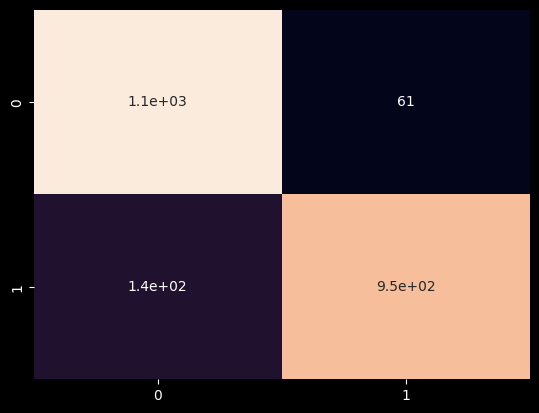

In [15]:
# Impostiamo i parametri ottimali per il modello
rfc.set_params(**best_params)

# Alleniamo il modello sul train set
rfc.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = rfc.predict(X_test)

# Infine valutiamo le previsioni
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False);
print(classification_report(y_test, y_pred))

### Metodo 3 - Ray

[Ray](https://docs.ray.io/en/latest/tune/index.html) è una libreria che offre diverse funzionalità utili per la creazione di modelli di ML, come gestione del training distribuito, logging e ottimizzazione degli iperparametri. 

Nel nostro caso utilizzeremo l'algoritmo offerto dalla libreria [Hyperopt](http://hyperopt.github.io/hyperopt/), che utilizza un metodo chiamato [Tree Parzen Estimator](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf).

Per prima cosa dobbiamo preparare lo spazio dei parametri da utilizzare. A differenza dei metodi precedenti, in questo caso i range delle singole variabili vanno specificati usando gli [strumenti offerti dalla libreria](https://docs.ray.io/en/latest/tune/api/search_space.html).

In [16]:
from ray import tune, train

search_space = {
    "n_estimators": tune.lograndint(10, 1000),
    "max_depth": tune.randint(1,10),
    "min_samples_split":tune.randint(2,10),
    "min_samples_leaf": tune.randint(1,10),
    "max_features": tune.choice(["sqrt", "log2"]),
    "bootstrap": tune.choice([True, False]),
    "criterion": tune.choice(["gini","entropy"]),
}

Ora costruiamo la funzione che Ray andrà ad ottimizzare.

In [17]:
def objective(config):
    score = cross_val_score(RandomForestClassifier(**config), X_train, y_train, cv=5)
    train.report({"score": score.mean()})

Ora possiamo ottimizzare questa funzione (quindi massimizzare lo score rispetto agli iperparametri) utilizzando la classe `Tuner`.

In [18]:
from ray.tune.search.hyperopt import HyperOptSearch

tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        search_alg=HyperOptSearch(random_state_seed=42),
        num_samples=100,
        metric="score",
        mode = "max",
    ),
    param_space=search_space
)

results=tuner.fit()

2023-10-19 17:13:29,054	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
(bundle_reservation_check_func pid=65006) Traceback (most recent call last):
(bundle_reservation_check_func pid=65006)   File "python/ray/_raylet.pyx", line 1590, in ray._raylet.execute_task
(bundle_reservation_check_func pid=65006)   File "python/ray/_raylet.pyx", line 1592, in ray._raylet.execute_task
(bundle_reservation_check_func pid=65006)   File "/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/ray/_private/worker.py", line 727, in deserialize_objects
(bundle_reservation_check_func pid=65006)     context = self.get_serialization_context()
(bundle_reservation_check_func pid=65006)               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(bundle_reservation_check_func pid=65006)   File "/Users/akmalsoliev/Coding/work/Python-Data-Sci

Infine valutiamo le performance del modello con questi parametri, allenato sul train set e valutato sul test set.

Best hyperparameters:
 {'n_estimators': 419, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'} 
with best mean score: 92.48%
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91      1128
         1.0       0.94      0.86      0.90      1091

    accuracy                           0.90      2219
   macro avg       0.91      0.90      0.90      2219
weighted avg       0.91      0.90      0.90      2219



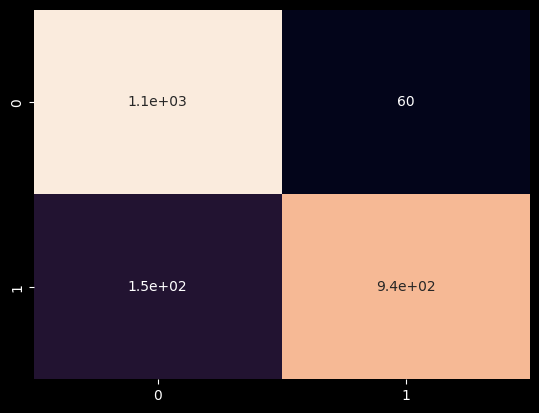

In [19]:
best_score = results.get_best_result().metrics["score"]
best_params = results.get_best_result().config
print("Best hyperparameters:\n",best_params,"\nwith best mean score: {:.2%}".format(best_score))

# Impostiamo i parametri ottimali per il modello
rfc.set_params(**best_params)

# Alleniamo il modello sul train set
rfc.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = rfc.predict(X_test)

# Infine valutiamo le previsioni
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cbar=False)
print(classification_report(y_test, y_pred))

Notiamo che, fra i tre metodi, questo ci ha dato il modello migliore in tempi minimali.

## Selezione degli iperparametri - Regressione

Ripetiamo ora il processo appena attuato, questa volta per il nostro modello di regressione, `XGBRegressor`. Dato che conosciamo già i metodi principali, ci concentreremo sull'arricchire le informazioni ottenute dalla cross-validation, perciò useremo la funzione `cross_validate` di `sklearn`.

In [20]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate

# Importiamo i dati necessari
X_train, y_train, X_test, y_test = regression_data

# Testiamo cross_validate
score_names = ["neg_mean_squared_error","neg_root_mean_squared_error", "neg_mean_absolute_error"]
scores = cross_validate(XGBRegressor(), X_train, y_train, cv=5, scoring=score_names)

# Definiamo una funzione per ottenere le metriche attese (medie sulle fold e con segno positivo)
def fix_scores(scores):
    fixed_scores = dict()
    for key in scores:
        if "test_" in key:
            fixed_scores[key.replace("test_neg_", "")]=-scores[key].mean()
        else:
            fixed_scores[key]=scores[key].mean()
    return fixed_scores

display(scores, fix_scores(scores))

/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is

{'fit_time': array([0.29538107, 0.11020708, 0.10429692, 0.10717893, 0.12983203]),
 'score_time': array([0.00290895, 0.00283694, 0.00396705, 0.00314999, 0.00277495]),
 'test_neg_mean_squared_error': array([-0.8658967 , -0.86230778, -0.84235103, -0.86488194, -0.88187226]),
 'test_neg_root_mean_squared_error': array([-0.9305357 , -0.92860529, -0.91779683, -0.92999029, -0.93908054]),
 'test_neg_mean_absolute_error': array([-0.79519347, -0.79099356, -0.77625021, -0.7548647 , -0.75252778])}

{'fit_time': 0.14937920570373536,
 'score_time': 0.003127574920654297,
 'mean_squared_error': 0.8634619424272459,
 'root_mean_squared_error': 0.9292017318677332,
 'mean_absolute_error': 0.773965943044649}

Notiamo alcune cose:

- La funzione `cross_validate` ci dà più informazioni riguardo a ciascuna fold dei dati
- Questa funzione ci permette di usare più di una metrica alla volta
- Le metriche di regressione rese disponibili da `sklearn` hanno il segno negativo (quindi vogliamo massimizzarle).

Possiamo ora passare alla selezione degli iperparametri usando `ray`, questa volta con più informazioni disponibili.

In [21]:
# Creiamo uno spazio di iperparametri da esplorare
search_space = {
    # Il numero di alberi da costruire
    "n_estimators": tune.choice([100, 200, 300, 400, 500]),
    # La profondità massima di ogni albero
    "max_depth": tune.randint(1,7),
    # Il tasso di apprendimento, che controlla il peso dei nuovi alberi aggiunti al modello
    "learning_rate": tune.loguniform(0.001, 0.1),
    # Il parametro di regolarizzazione che riduce l'overfitting penalizzando i pesi degli alberi
    "gamma": tune.uniform(0, 1),
    # Il parametro di regolarizzazione L2 che controlla la complessità dei pesi delle foglie
    "reg_lambda": tune.uniform(0, 10),
    # Il parametro di regolarizzazione L1 che controlla la sparsità dei pesi delle foglie
    "reg_alpha": tune.uniform(0, 10),
    # La frazione di osservazioni da campionare per ogni albero
    "subsample": tune.uniform(0.5, 1),
    # La frazione di colonne da campionare per ogni albero
    "colsample_bytree": tune.uniform(0.5, 1),
    # La funzione obiettivo da usare per il modello (ad esempio regressione lineare o regressione logistica)
    "objective": tune.choice(["reg:squarederror", "reg:absoluteerror"]),
}

# Definiamo una nuova funzione obiettivo
def objective(config):
    scores = cross_validate(XGBRegressor(**config), X_train, y_train, cv=5, scoring=score_names, error_score="raise")
    fixed_scores = fix_scores(scores)
    train.report(fixed_scores)

tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        search_alg=HyperOptSearch(random_state_seed=42),
        num_samples=100,
        metric="root_mean_squared_error",
        mode = "min",
    ),
    param_space=search_space,

)

results=tuner.fit()


(objective pid=65848) /Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
(objective pid=65848)   if is_sparse(dtype):
(objective pid=65848) /Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
(objective pid=65848)   is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
(objective pid=65848) /Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
(objective pid=65848)   if is_categorical_dtype(dtype):
(objective pi

In [22]:
results.get_best_result().metrics

{'fit_time': 0.22916779518127442,
 'score_time': 0.012344169616699218,
 'mean_squared_error': 0.7916615067282444,
 'root_mean_squared_error': 0.8897255311472729,
 'mean_absolute_error': 0.7544165096432123,
 'timestamp': 1697728640,
 'done': True,
 'training_iteration': 1,
 'trial_id': '56abddbd',
 'date': '2023-10-19_17-17-20',
 'time_this_iter_s': 1.2120311260223389,
 'time_total_s': 1.2120311260223389,
 'pid': 65891,
 'hostname': 'Akmals-MacBook-Pro.local',
 'node_ip': '127.0.0.1',
 'config': {'n_estimators': 200,
  'max_depth': 5,
  'learning_rate': 0.047032120370397806,
  'gamma': 0.03794004627370509,
  'reg_lambda': 0.0253664990212652,
  'reg_alpha': 9.964288614986742,
  'subsample': 0.8250163851560812,
  'colsample_bytree': 0.5264491083554702,
  'objective': 'reg:squarederror'},
 'time_since_restore': 1.2120311260223389,
 'iterations_since_restore': 1,
 'checkpoint_dir_name': None,
 'experiment_tag': '71_colsample_bytree=0.5264,gamma=0.0379,learning_rate=0.0470,max_depth=5,n_esti

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

best_mse = results.get_best_result().metrics["mean_squared_error"]
best_rmse = results.get_best_result().metrics["root_mean_squared_error"]
best_mae = results.get_best_result().metrics["mean_absolute_error"]
best_params = results.get_best_result().config
print("Best hyperparameters:\n",best_params,"\nwith scores:\nMSE: ", best_mse, "RMSE: ", best_rmse, "MAE: ", best_mae)

xgbr = XGBRegressor()
# Impostiamo i parametri ottimali per il modello
xgbr.set_params(**best_params)

# Alleniamo il modello sul train set
xgbr.fit(X_train, y_train)

# Calcoliamo le previsioni del modello sul test set
y_pred = xgbr.predict(X_test)

print(f"Best model test scores:\nMSE: {mean_squared_error(y_test,y_pred)}\nRMSE: {mean_squared_error(y_test,y_pred, squared=False)}\nMAE: {mean_absolute_error(y_test,y_pred)}")

/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is

Best hyperparameters:
 {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.047032120370397806, 'gamma': 0.03794004627370509, 'reg_lambda': 0.0253664990212652, 'reg_alpha': 9.964288614986742, 'subsample': 0.8250163851560812, 'colsample_bytree': 0.5264491083554702, 'objective': 'reg:squarederror'} 
with scores:
MSE:  0.7916615067282444 RMSE:  0.8897255311472729 MAE:  0.7544165096432123
Best model test scores:
MSE: 0.785479194719603
RMSE: 0.886272641301537
MAE: 0.7522081005122481


/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/akmalsoliev/Coding/work/Python-Data-Science/.venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is

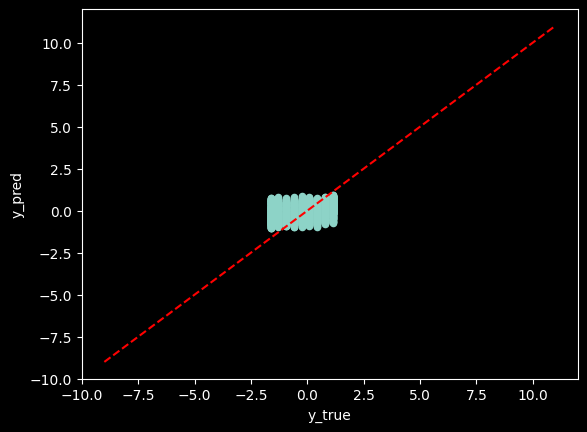

In [24]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred})

fig, ax = plt.subplots()
results_df.plot.scatter("y_true", "y_pred", ax=ax)
ax.plot(range(-9,12),range(-9,12), linestyle="dashed", color="red")

## Salvataggio e caricamento dei modelli scelti

Utilizzando i file pickle possiamo facilmente salvare i nostri modelli come artefatti per riutilizzarli successivamente.

In [32]:
# Creazione della cartella per salvare i modelli
if not os.path.exists("models"):
    os.mkdir("models")

# Salvataggio dei modelli
with open("models/classification_model.pickle", "wb") as file:
    pickle.dump(rfc, file)
with open("models/regression_model.pickle", "wb") as file:
    pickle.dump(xgbr, file)